## ARIMA and Seasonal ARIMA (SARIMA)

### ARIMA 모델

__ARIMA : AutoRegressive Intefrated Moving Average__  
개발된 지 오래된 방법으로, 시계열 데이터 분석을 위해 이해해야 하는 중요한 모델링 또는 예측 기법이다.

- Autoregressive - AR(p)
- Integrated - I(d)
- Movind Average - MA(q)

---

### Stationary

기본적으로 ARIMA 는 Stationary 데이터임을 전제조건으로 한다.

#### Stationary 데이터의 특성 ?  
- 임의의 구간의 평균(Mean)이 항상 일정
- 임의의 구간의 분산(Variance)이 항상 일정
- 연속되는 숫자들의 공분산(Covariance)이 항상 일정

#### Stationary 임을 확인 ?

Augmented Dickey Fuller 테스트 기법을 활용한다.
> statsmodels.tsa.stattools 안의 adfuller 를 사용한다.

---

### Differencing - d

- Non-Stationary 데이터는 differencing 을 통해 stationary 하게 변환한다.
- Differencing 한 데이터는 stationary 조건을 만족할 때 까지 differencing 을 반복한다.
- Seasonal 데이터일 경우, season 을 기준으로 differencing 한다.
 - 예를 들어, 1년 주기의 seasonality 를 갖는 월간 데이터에 대해 differencing 을 할 때, diff 의 단위는 1 이 아니라 12 가 된다.
 - SARIMA 모델의 경우 1차 diff 후에 seasonal diff 를 하는 것도 흔히 사용하는 방법이다.

### Autoregression (AR) - p

t 시점의 데이터와 이전 시점 (t-p; lagged p) 의 데이터 사이의 관계에 대한 회귀 모델

### Moving Average (MA) - q

t 시점의 데이터와 이전 시점 (t-p; lagged p) 의 moving average  에 대한 회귀 모델

---

### Auto Correlation Plot

t 시점과 특정 시간만큼 지연된(lagged) 시점의 데이터(t-p)와의 연관성을 보여준다.

### Partial Auto Correlation Plot

t 시점과 특정 시간만큼 지연된(lagged) 시점의 데이터(t-p)와의 연관성을  
그 사이 데이터들의 영향을 배제하고 보여준다.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [2]:
df = pd.read_csv(
    "data/monthly-milk-production.csv",
    index_col='Month',
    parse_dates=True
)

In [3]:
df.head()

,pounds per cow
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


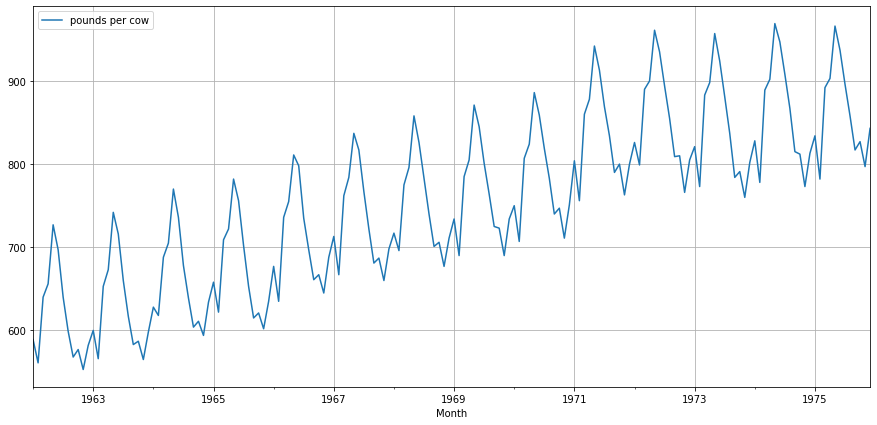

In [4]:
df.plot(figsize=(15, 7))
plt.grid(True)

plt.show()

일반적으로 다음 프로세스를 따라 ARIMA 모델을 만든다.

- 시계열 데이터 시각화
- 시계열 데이터를 stationary 특성화
- Correlation 과 AutoCorrelation 차트 플로팅
- ARIMA 모델 생성
- 만들어진 모델로 예측 수행

### Step 1 : 시계열 데이터 시각화

#### Visualize

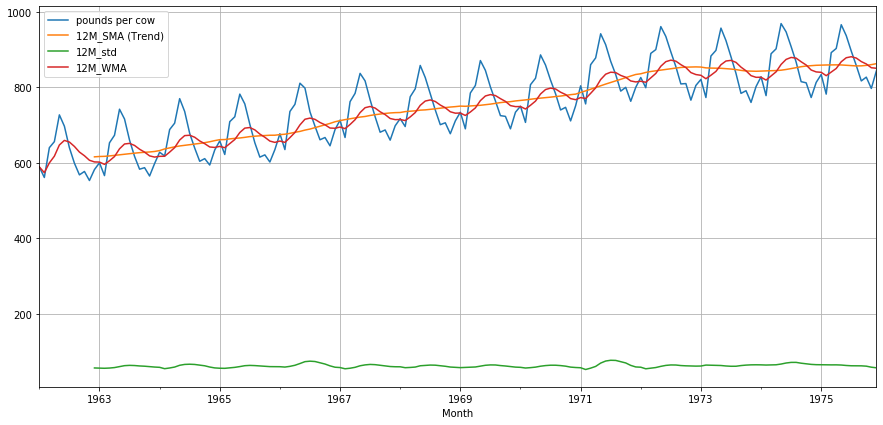

In [5]:
fig = plt.figure(figsize=(15, 7))

df['pounds per cow'].plot()
df['pounds per cow'].rolling(window=12).mean().plot(label='12M_SMA (Trend)')
df['pounds per cow'].rolling(window=12).std().plot(label='12M_std')
df['pounds per cow'].ewm(span=12).mean().plot(label='12M_WMA')

plt.grid(True)
plt.legend()

plt.show()

#### Decomposition

In [6]:
decomposition = seasonal_decompose(df['pounds per cow'])

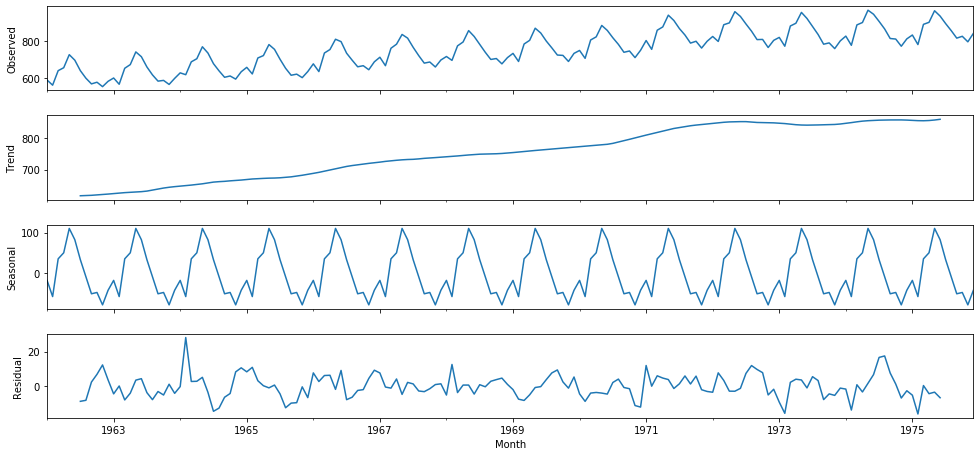

In [7]:
fig = decomposition.plot()
fig.set_size_inches(15, 7)

### Step 2 : 시계열 데이터를 stationary 특성화

시계열 데이터의 Stationarity 특성을 시험하기 위해 Augmented Dickey-Fuller(ADF) unit root test 를 사용한다.  
  
ADF test 는 시계열 데이터 샘플에 단위근(unit root)이 존재한다는 귀무가설을 시험함으로써 대립가설인 stationarity 또는 trend-stationarity 여부를 확인한다.  
  
시계열 데이터에 unit root 가 있어 non-stationary 하다는 귀무가설 H0 을 accept 할 지, 또는 이를 reject 하면서 시계열 데이터에 unit root 가 없고 stationary 하다는 대립가설을 채택할 지를 실험하는 것이다.  
  
결국 결과값 p-value 로 결정하게 된다.

- p-value 값이 작을 때 (<= 0.05), 귀무가설을 reject 하고 데이터는 stationary 함
- p-value 값이 클 때 (>= 0.05), 귀무가설을 accept 하고 데이터는 non-stationary 함

In [8]:
adf_result = adfuller(df['pounds per cow'])

In [9]:
adf_result  # 여기서 2번째 값이 p-value 이다.

(-1.3038115874221263,
 0.6274267086030331,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [10]:
def check_adf(series_data):
    adf_result = adfuller(series_data)
    
    if adf_result[1] <= 0.05:
        print("Stationary (p-value : {})".format(adf_result[1]))
    else:
        print("Non-Stationary (p-value : {})".format(adf_result[1]))

In [11]:
check_adf(df['pounds per cow'])

Non-Stationary (p-value : 0.6274267086030331)


#### Differencing

시계열 데이터에 대한 1차 difference 는 다음 스텝으로의 한 차원(시간단위) 만큼의 변화값이 series 이다. 2차, 3차, 그 보다 놓은 차원의 differencing 을 시도해보고 stationary 한 차원을 찾는다.

##### First Difference

In [12]:
df['1st_diff'] = df['pounds per cow'] - df['pounds per cow'].shift(1)

In [13]:
df.head()

,pounds per cow,1st_diff
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0
1962-04-01,656,16.0
1962-05-01,727,71.0


In [14]:
check_adf(df['1st_diff'].dropna())

Stationary (p-value : 0.030068004001785713)


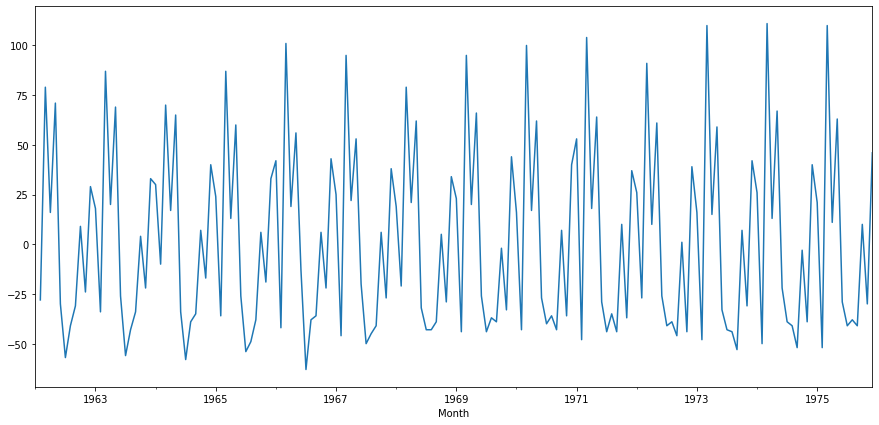

In [15]:
df['1st_diff'].plot(figsize=(15, 7));

##### Second Difference

In [16]:
df['2nd_diff'] = df['1st_diff'] - df['1st_diff'].shift(1)

In [17]:
df.head()

,pounds per cow,1st_diff,2nd_diff
Month,,,
1962-01-01,589,NaN,NaN
1962-02-01,561,-28.0,NaN
1962-03-01,640,79.0,107.0
1962-04-01,656,16.0,-63.0
1962-05-01,727,71.0,55.0


In [18]:
check_adf(df['2nd_diff'].dropna())

Stationary (p-value : 1.1126989332080988e-26)


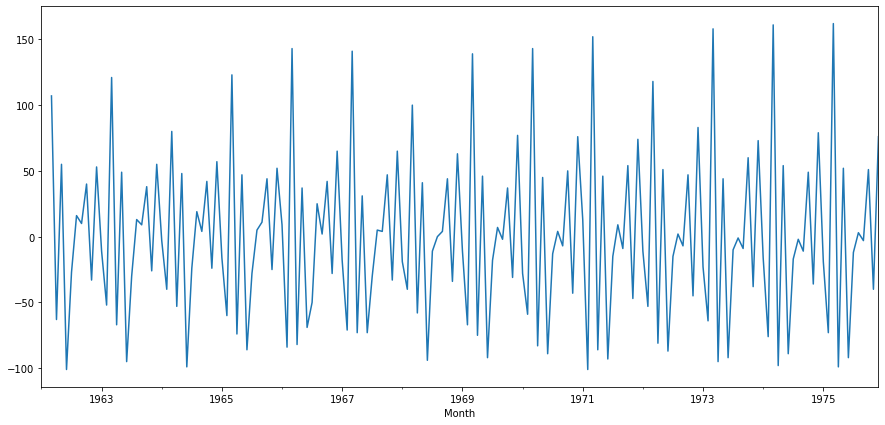

In [19]:
df['2nd_diff'].plot(figsize=(15, 7));

#### Seasonal Differencing

위의 Differencing 과 마찬가지로, 1차 difference 데이터, 2차 difference 데이터에 대해서도 수행해본다.

In [20]:
df['seasonal_diff'] = df['pounds per cow'] - df['pounds per cow'].shift(12)

In [21]:
check_adf(df['seasonal_diff'].dropna())

Non-Stationary (p-value : 0.16079880527711332)


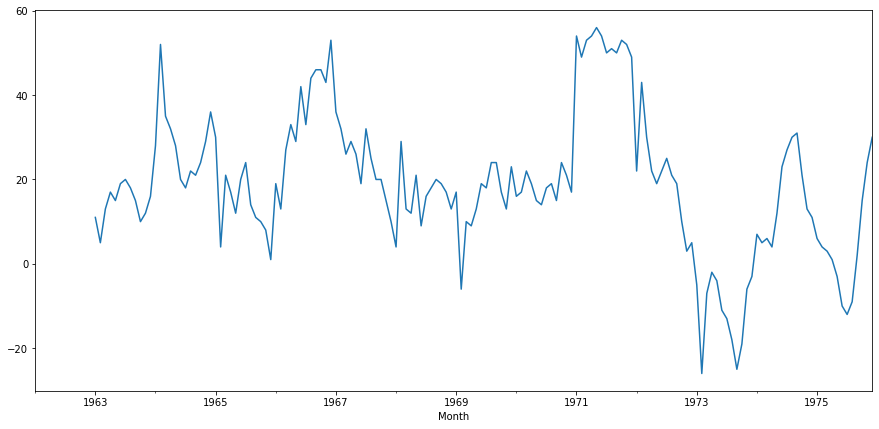

In [22]:
df['seasonal_diff'].plot(figsize=(15, 7));

##### Seasonal First Difference

In [23]:
df['seasonal_1st_diff'] = df['1st_diff'] - df['1st_diff'].shift(12)

In [24]:
check_adf(df['seasonal_1st_diff'].dropna())

Stationary (p-value : 1.865423431878935e-05)


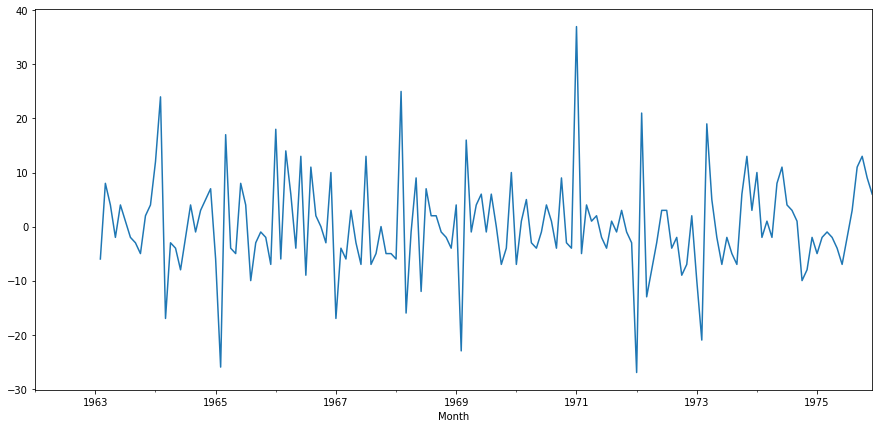

In [25]:
df['seasonal_1st_diff'].plot(figsize=(15, 7));

__위와 같은 과정을 통해 d = 1, D = 1 의 파라미터를 찾았다.__

### Step 3 : Correlation 과 AutoCorrelation 차트 플로팅

ARIMA 의 p, q 파라미터를 찾기 위해 PACF 와 ACF 플롯을 참조한다.

플롯에 대한 해석은 간단하지 않다.

- http://people.duke.edu/~rnau/arimrule.htm
- https://people.duke.edu/~rnau/411arim3.htm

을 참조하여 ACF 와 PACF 를 해석하는 방법을 자세히 알 수 있다.

#### Autocorrelation Interpretation

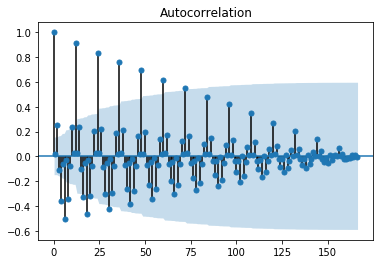

In [51]:
dropped_1st_diff = df['1st_diff'].dropna()
plot_acf(dropped_1st_diff, lags=len(dropped_1st_diff) - 1);

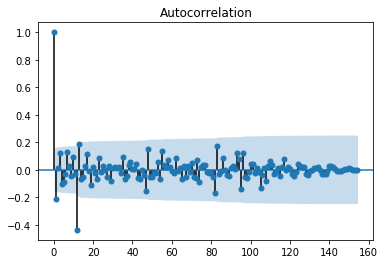

In [52]:
dropped_seasonal_1st_diff = df['seasonal_1st_diff'].dropna()
plot_acf(dropped_seasonal_1st_diff, lags=len(dropped_seasonal_1st_diff) - 1);

#### Partial Autocorrelation

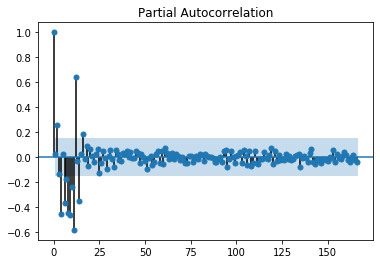

In [57]:
plot_pacf(dropped_1st_diff, lags=len(dropped_1st_diff) - 1, method='ywm');

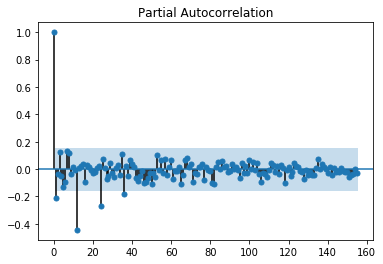

In [59]:
plot_pacf(dropped_seasonal_1st_diff, lags=len(dropped_seasonal_1st_diff), method='ywm');

#### Autocorrelation 과 Partial Autocorrelation 에 대한 정리

- AR 모델 판별은 대체로 PACF 를 통해 확인 가능하다.  
 이론적으로 PACF 는 AR 모델의 차수 이후 "shut off" 를 보인다.  
 "shut off" 되었다는 것은 partial autocorrelation 이 해당 지점 이후 0 과 같다는 의미이다.  

__즉, 0 이 아닌 partial auto correlation 이 존재하는 차수가 AR 모델의 차수가 된다.__

- MA 모델 판별은 대체로 ACF 를 통해 확인 가능하다.  
  MA 모델에 있어서 PACF 는 "shut off" 하지 않지만, 0을 향해 점진적으로 줄어든다.  
  ACF 에 MA 모델이 좀 더 분명하게 나타나는데, 모델에 관련된 lag 에 대해서만 0 이 아닌 autocorrelation 이 나타난다.

### Step 4 : ARIMA 모델 생성

In [61]:
model = sm.tsa.statespace.SARIMAX(
    df['pounds per cow'],
    order=(0, 1, 0),
    seasonal_order=(1, 1 ,1, 12)
)

/mnt/d/Study/AI/Time-Series-Analysis-and-ARIMA/time-series-analysis-and-arima/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [62]:
model_result = model.fit()

In [64]:
print(model_result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Tue, 24 Sep 2019   AIC                           1074.131
Time:                                    13:18:54   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

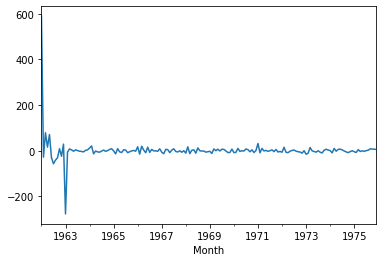

In [66]:
model_result.resid.plot();

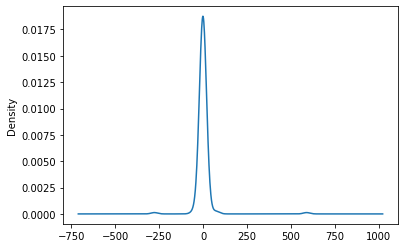

In [68]:
model_result.resid.plot(kind='kde');

### Step 5 : 만들어진 모델로 예측 수행

생성된 모델이 이미 알고 있는 결과 대비 얼마나 좋은 예측 성능을 보여주는 지 확인한다.

In [73]:
df['forecast'] = model_result.predict(start=150, end=168, dynamic=True)

In [74]:
df[['pounds per cow', 'forecast']].tail(10)

,pounds per cow,forecast
Month,,
1975-03-01,892,912.267842
1975-04-01,903,926.505911
1975-05-01,966,989.604709
1975-06-01,937,962.944932
1975-07-01,896,919.999544
1975-08-01,858,879.668972
1975-09-01,817,832.328551
1975-10-01,827,837.722247
1975-11-01,797,802.452733


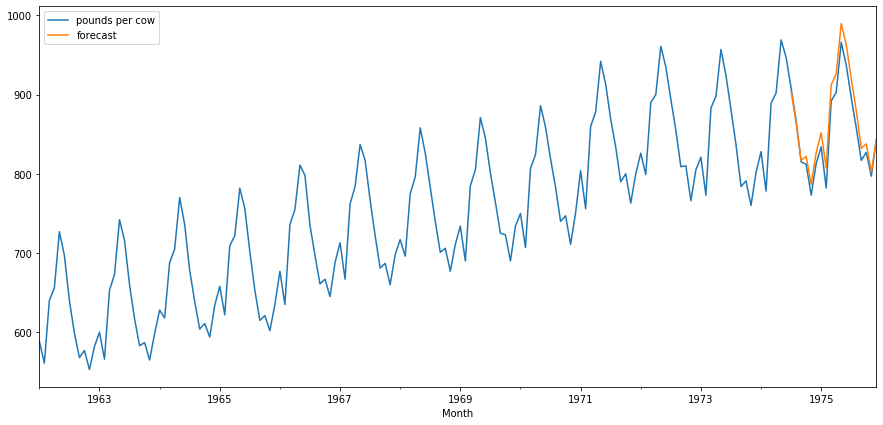

In [76]:
df[['pounds per cow', 'forecast']].plot(figsize=(15, 7));